# sciket-learn

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import scipy
from IPython.display import HTML

print(sys.version)
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('sciket-learn: {}'.format(sklearn.__version__))
print('scipy: {}'.format(scipy.__version__))

matplotlib.style.use('ggplot')

3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:22:27) 
[GCC 9.3.0]
NumPy: 1.20.1
pandas: 1.2.3
Matplotlib: 3.3.4
sciket-learn: 0.24.1
scipy: 1.6.1


In [2]:
%%html
<style>
table {float:left}
</style>

## 欠損値への対応

In [3]:
# データの用意
df = pd.DataFrame(
    {
        'A': [1, np.nan, 3, 4, 5],
        'B': [6, 7, 8, np.nan, 10],
        'C': [11, 12, 13, 14, 15]
    }
)
df

,A,B,C
0,1.0,6.0,11
1,NaN,7.0,12
2,3.0,8.0,13
3,4.0,NaN,14
4,5.0,10.0,15


### 欠損値の除去

pandasを利用して実行する例

In [4]:
# 各要素の欠損値を確認する
df.isnull()

,A,B,C
0,False,False,False
1,True,False,False
2,False,False,False
3,False,True,False
4,False,False,False


In [5]:
# 欠損値の行を削除
df.dropna()

,A,B,C
0,1.0,6.0,11
2,3.0,8.0,13
4,5.0,10.0,15


### 欠損値の補完

pandasでは`fillna`メソッドを利用することになるが、sciket-learnでの手順を確認

In [6]:
from sklearn.impute import SimpleImputer

# 列に対して、平均値の値で補完をするImputerインスタンスを作成
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(df)
imp.transform(df)

array([[ 1.  ,  6.  , 11.  ],
       [ 3.25,  7.  , 12.  ],
       [ 3.  ,  8.  , 13.  ],
       [ 4.  ,  7.75, 14.  ],
       [ 5.  , 10.  , 15.  ]])

[sklearn.impute.SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

> **strategystring, default=’mean’**  
> The imputation strategy.  
>  
> ・If “mean”, then replace missing values using the mean along each column. Can only be used with numeric data.  
> ・If “median”, then replace missing values using the median along each column. Can only be used with numeric data.  
> ・If “most_frequent”, then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.  
> ・If “constant”, then replace missing values with fill_value. Can be used with strings or numeric data.  

## カテゴリ変数のエンコーディング

- カテゴリ変数のエンコーディング
  - カテゴリ変数を数値(整数)に変換する処理
  - 例えば
    - 「a」を「0」に、「b」を「1」に、のように変換する
- One-hotエンコーディング
  - カテゴリ変数を符号化する処理
    - pandasにおける`get_dummies`関数のような処理のこと
  - `ダミー変数化`とも言う
    - 生成された列の変数を`ダミー変数`と言う

In [7]:
# データの用意
df = pd.DataFrame(
    {
        'A': [1, 2, 3, 4, 5],
        'B': ['a', 'b', 'a', 'b', 'c']
    }
)
df

,A,B
0,1,a
1,2,b
2,3,a
3,4,b
4,5,c


### カテゴリ変数のエンコーディング

[sklearn.preprocessing.LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

In [8]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoderのインスタンスを作成 
le = LabelEncoder()
# B列に対して、エンコーディングを実施
le.fit(df['B'])
le.transform(df['B'])

array([0, 1, 0, 1, 2])

### One-hotエンコーディング

[skleran.compose.ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)

> Applies transformers to columns of an array or pandas DataFrame.  
> This estimator allows different columns or column subsets of the input to be transformed separately and the features generated by each transformer will be concatenated to form a single feature space. This is useful for heterogeneous or columnar data, to combine several feature extraction mechanisms or transformations into a single transformer.

[sklearn.preprocessing.OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

> Encode categorical features as a one-hot numeric array.  
> The input to this transformer should be an array-like of integers or strings, denoting the values taken on by categorical (discrete) features. The features are encoded using a one-hot (aka ‘one-of-K’ or ‘dummy’) encoding scheme.

pandasでは`get_dummies`関数で実現できるが、sciket-learnでの手順を確認

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# DataFrameをコピー
df_ohe = df.copy()

# ColumnTransformerのインスタンス化
column_trans = ColumnTransformer(transformers=[('test', OneHotEncoder(), ['B'])], remainder='passthrough')
# 変換(値をOneHotEncoderしつつ、ColumnTransformerしてくれる)
column_trans.fit_transform(df_ohe)

array([[1., 0., 0., 1.],
       [0., 1., 0., 2.],
       [1., 0., 0., 3.],
       [0., 1., 0., 4.],
       [0., 0., 1., 5.]])

- 疎行列(sparse matrix)
  - 成分のほとんどが0である行列のこと
  - 上記のダミー変数化された行列のようなもの
- 密行列
  - 成分のほとんどが1である行列のこと

## 特徴量の正規化
特徴量の大きさ(尺度)を揃える処理
- 分散正規化
  - 特徴量の平均が0、標準偏差が1となるように、特徴量を変換
- 最小最大正規化
  - 特徴量の最小値が0、最大値が1となるように、特徴量を変換

In [10]:
# データの用意
df = pd.DataFrame(
    {
        'A': [1, 2, 3, 4, 5],
        'B': [100, 200, 300, 400, 500]
    }
)
df

,A,B
0,1,100
1,2,200
2,3,300
3,4,400
4,5,500


### 分散正規化
[sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=standardscaler#sklearn.preprocessing.StandardScaler)

In [11]:
from sklearn.preprocessing import StandardScaler

# 分散正規化のインスタンスを作成
stdsc = StandardScaler()

# 分散正規化を実行
stdsc.fit(df)
stdsc.transform(df)

array([[-1.41421356, -1.41421356],
       [-0.70710678, -0.70710678],
       [ 0.        ,  0.        ],
       [ 0.70710678,  0.70710678],
       [ 1.41421356,  1.41421356]])

### 最小最大正規化
[sklearn.preprocessing.MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html?highlight=minmaxscaler#sklearn.preprocessing.MinMaxScaler)

In [12]:
from sklearn.preprocessing import MinMaxScaler

# 最小最大正規化のインスタンスを作成
mmsc = MinMaxScaler()

# 最小最大正規化を実行
mmsc.fit(df)
mmsc.transform(df)

array([[0.  , 0.  ],
       [0.25, 0.25],
       [0.5 , 0.5 ],
       [0.75, 0.75],
       [1.  , 1.  ]])

## 学習データとテストデータ

- 学習データ
  - データセットより、モデル学習用に用意したデータ
- テストデータ
  - データセットより、作成モデルの検証用に用意したデータ
  - 未知データに対する対応能力(`汎化能力`)を評価

### sciket-learnにおける学習データとテストデータの分割

[sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split)

In [13]:
# Irisデータセットの読み込み
# 150枚のあやめの「がく」や「花びら」の長さと幅、そして花の種類を記録したデータ
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data, iris.target

# 学習データとテストデータを分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
print('X_train: {}'.format(X_train.shape))
print('X_test: {}'.format(X_test.shape))
print('y_train: {}'.format(y_train.shape))
print('y_test: {}'.format(y_test.shape))

X_train: (105, 4)
X_test: (45, 4)
y_train: (105,)
y_test: (45,)


## 分類

### サポートベクタマシン(support vector machine, SVM)による分類処理

- サポートベクタマシンとは
  - 以下に利用可能なアルゴリズム
    - 分類
    - 回帰
    - 外れ値検索
- 線形分離できないデータを、高次元の空間に写して分類する
  - `カーネル` とう概念を利用
    - データ間の近さを定量化する指数
    - 高次元空間のデータ間内積を計算する関数に相当
      - linear
      - 動径基底関数(radial basis function, rbf)
- `サポートベクタ` 間の `マージン` が最大となるように `決定境界` の線を引く
  - `サポートベクタ` とは、各クラスのデータ
  - `マージン` とは、クラス間のサポートベクタの距離
- 絶対値の極端に大きい特徴量に、分類結果が影響を受けやすい
  - そのために正規化を必要とする

In [14]:
from sklearn.svm import SVC

# 学習、および決定協会、マージン、サポートベクタを可視化する関数
def plot_boundary_margin_sv(X0, y0, X1, y1, kernel, C, xmin=-1, xmax=1, ymin=-1, ymax=1):
    
    # サポートベクタマシンのインスタンス化
    svc = SVC(kernel=kernel, C=C)
    
    # 学習
    svc.fit(np.vstack((X0, X1)), np.hstack((y0, y1)))
    
    fig, ax = plt.subplots()
    ax.scatter(X0[:, 0], X0[:, 1], marker='o', label='class 0')
    ax.scatter(X1[:, 0], X1[:, 1], marker='x', label='class 1')
    
    # 決定協会とマージンをプロット
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))
    xy = np.vstack([xx.ravel(), yy.ravel()]).T
    p = svc.decision_function(xy).reshape((100, 100))
    ax.contour(xx, yy, p, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    
    # サポートベクタをプロット
    ax.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=250, facecolors='none', edgecolors='black')
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(loc='best')
    plt.show()

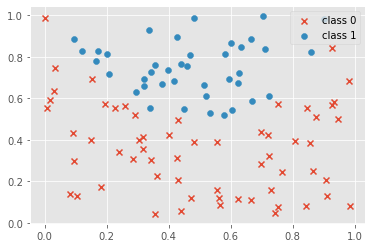

In [15]:
np.random.seed(123)

# データの用意
X = np.random.random(size=(100, 2))
y = (X[:, 1] > 2*(X[:, 0]-0.5)**2 +0.5).astype(int)

fig, ax = plt.subplots()
ax.scatter(X[y == 0, 0], X[y ==0, 1], marker='x', label='class 0')
ax.scatter(X[y == 1, 0], X[y == 1, 1], marker='o', label='class 1')
ax.legend()
plt.show()

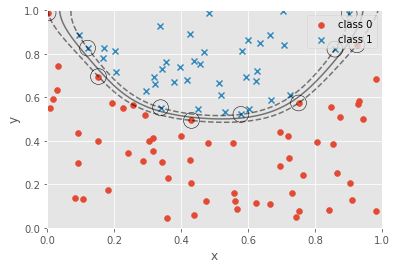

In [16]:
# 上で作った関数を利用して、決定境界・マージン・サポートベクタをプロット
X0, X1 = X[y == 0, :], X[y == 1, :]
y0, y1 = y[y == 0], y[y == 1]
plot_boundary_margin_sv(X0, y0, X1, y1, kernel='rbf', C=1e3, xmin=0, ymin=0)

- 実線が決定境界
- 破線がマージン
- 丸印がサポートベクタ

### 決定木(decision tree)による分類

- データを分割するルールを作成して、データを分類するアルゴリズム
  - B-treeみたいな感じ
- `情報利得`と`不純度`を判定する
  - 情報利得とは、データを分割することによって、どれだけ得をするかを示す指標
    - 親ノードの不純度から、子ノードの不純度の合計を引いたもの
  - 不純度とは、どれだけデータが混在しているかの指標
    - ジニ不純度
      - sciket-learnでは、デフォルトで利用される
    - エントロピー
    - 分類誤差

#### ジニ不純度の求め方

- `どれだけデータが混在しているかの指標`
  - つまり、`各ノードに間違ったクラスが振り分けられてしまう確率`のこと

例えば、`class 0`と`class 1`に分類するノードにて、予測と実際の割合が以下の時

<table>
<tr>
  <td colspan="2" rowspan="2"></td>
  <td colspan="2" align="center">予測(振り分け結果)</td>
</tr>
<tr>
  <td align="center">class 0</td>
  <td align="center">class 1</td>
</tr>
<tr>
  <td rowspan="2">実際</td>
  <td>class 0</td>
  <td align="center">0.60 P(0)</td>
  <td align="center">0.40 P(1-P(0))</td>
</tr>
<tr>
  <td>class 1</td>
  <td align="center">0.40 P(1-P(1))</td>
  <td align="center">0.60 P(1)</td>
</tr>
</table>


- 予測は`class 0`なのに、実際は`class 1`と割り振られる確率: P(1-P(0))
  - 0.4 * 0.6 = 0.24
- 予測は`class 1`なのに、実際は`class 0`と割り振られる確率: P(1-P(1))
  - 0.6 * 0.4 = 0.24
- 上記2つ合計して、「0.48」がジニ不純度の値(つまり、間違ったクラスに割り振られる確率)となる

数式では下記となる

$
P(0)(1-P(0))+P(1)(1-P(1)) = (P(0)+P(1))-(P(0)^2+P(1)^2) = 1-(P(0)^2+P(1)^2)
$

クラスがc個あるとした場合

$
\displaystyle
1-\sum_{c=0}^{c-1}P(c)^2
$


In [17]:
# Irisデータセットの用意
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data, iris.target

# 学習データとテストデータの分類
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

from sklearn.tree import DecisionTreeClassifier

# 決定木のインスタンス化(木の最大深さ=3)
tree = DecisionTreeClassifier(max_depth=3)

# 学習
tree.fit(X_train, y_train)

# 予測
y_pred = tree.predict(X_test)
y_pred

array([1, 2, 2, 1, 0, 1, 1, 0, 0, 1, 2, 0, 1, 2, 2, 2, 0, 0, 1, 0, 0, 1,
       0, 2, 0, 0, 0, 2, 2, 0, 2, 1, 0, 0, 1, 1, 2, 0, 0, 1, 1, 0, 2, 2,
       2])

[sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontreeclassifier#sklearn.tree.DecisionTreeClassifier)

作成した決定木を樹形図で表示する

表示には、Pythonライブラリ`pydotplus`と可視化ツール`graphviz`が必要であるため、Jupyter Notebook環境にインストールしておく

> !pip install pydotplus  
> !sudo apt install graphviz

In [18]:
# from pydotplus import graph_from_dot_data
# from sklearn.tree import export_graphviz
# dot形式のデータを抽出
# dot_data = export_graphviz(tree, filled=True,
#                 rounded=True,
#                 class_names=['Setosa',
#                      'Versicolor',
#                      'Virigica'],
#                 feature_names=['Speal Length',
#                                'Spal Width',
#                                'Petal Length',
#                                'Petal Width'],
#                 out_file=None)
# # 決定木のプロットを出力
# graph = graph_from_dot_data(dot_data)
# graph.write_png('tree.png')

以下のような樹形図の画像ファイルが作成される

![決定木のイメージ図](./img/tree.png)

### ランダムフォレスト(random forest)

- データのサンプル特徴量(說明変数)をランダムに選択し決定木(decision tree)による処理を複数回繰り返し、各木の推定結果の多数決や平均値により分類・回帰を行うアンサンブル学習
  - アンサンブル学習とは
    - 複数の学習器(ランダムフォレストは決定木のアンサンブルであると言える)を用いた学習方法のこと
- ブートストラップデータ
  - ランダムに選択されたサンプルと特徴量(説明変数)のデータ
  - ランダムフォレストで利用されるデータの呼称

In [36]:
# Irisデータセットの用意
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data, iris.target

# 学習データとテストデータの分類
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

from sklearn.ensemble import RandomForestClassifier

# ランダムフォレストのインスタンス化(n_estimatorsパラメーターは計算される決定木の個数)
forest = RandomForestClassifier(n_estimators=100, random_state=123)

# 学習
forest.fit(X_train, y_train)

# 予測
y_pred = forest.predict(X_test)
y_pred

array([1, 2, 2, 1, 0, 1, 1, 0, 0, 1, 2, 0, 1, 2, 2, 2, 0, 0, 1, 0, 0, 1,
       0, 2, 0, 0, 0, 2, 2, 0, 2, 1, 0, 0, 1, 1, 2, 0, 0, 1, 1, 0, 2, 2,
       2])

[sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

## 回帰

### 線形回帰

目的変数`y`を、説明変数(特徴量)`x`が`p`個あるとして、データを最もよく説明する係数`a`を求める

$
\displaystyle
y = a_0 + a_1x_1 + ... + a_px_p
$

- 線形回帰の種類
  - 単回帰
    - 説明変数が1つの変数の場合
  - 重回帰
    - 説明変数が複数の変数の場合

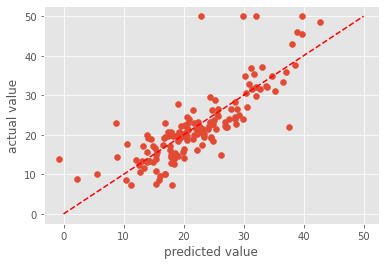

In [20]:
# Bostonデータセットを読み込む
# ボストン市郊外の地域別に、住宅価格と14個の特徴量を記録したデータ
from sklearn.datasets import load_boston
boston = load_boston()
X, y = boston.data, boston.target

# 学習データとテストデータに分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# 線形回帰をインスタンス化
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
# 学習
lr.fit(X_train, y_train)
# テストデータの予測
y_pred = lr.predict(X_test)

# X軸を予測値、Y軸を実績値とする散布図の描画
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test)
ax.plot((0, 50), (0, 50), linestyle='dashed', color='red')
ax.set_xlabel('predicted value')
ax.set_ylabel('actual value')
plt.show()

予測値と実績値が等しい値の近似で収束しており、作成した回帰のモデルがある程度正しく動作していることを確認できる

[sklearn.linear_model.LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html?highlight=linearregression#sklearn.linear_model.LinearRegression)

## 次元削減

### 主成分分析(principal component analysis, PCA)

高次元のデータに対して、分散が大きくなる方向(データが散らばっている方向)を探して、元の次元以下の低い次元に変換する手法

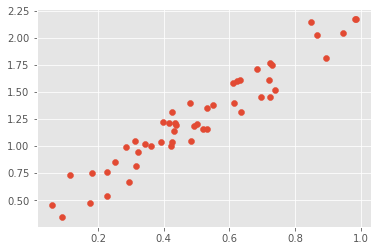

In [21]:
# データの用意

np.random.seed(123)
# 50個の一様乱数を作成
X = np.random.random(size=50)
# Xを2倍したものと、50個の一様乱数を0.5倍したものを、足したもの
Y = 2*X + 0.5*np.random.random(size=50)

# 散布図の描画
fig, ax = plt.subplots()
ax.scatter(X, Y)
plt.show()

[sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

> **Parameters:**  
> **n_components: int, float or ‘mle’, default=None**  
> Number of components to keep.

- 下記の例では`n_components=2`と指定しており、元々2次元のデータを、2成分になるように分析している
  - そのため次元の削減は行っていない
- 一方散布図を見ると、PC2(第2主成分)のデータは散らばりがすくなく、PC1(第1主成分)のデータが重要であることが分かる

> **fit_transform(X, y=None)**  
> Fit all transformers, transform the data and concatenate results.  
> **Parameters:**  
> X: {array-like, dataframe} of shape (n_samples, n_features)  
> y: array-like of shape (n_samples,), default=None



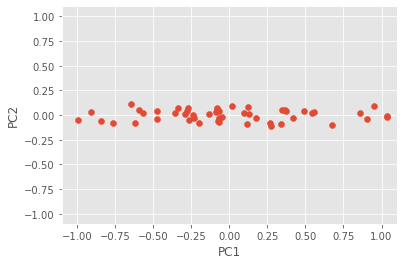

In [22]:
# 主成分分析を実行
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# 分析対象のデータは配列かDataFrameである必要あるため、用意したXとYのデータを、50x2の行列に変えて渡している
X_pca = pca.fit_transform(np.hstack((X[:, np.newaxis], Y[:, np.newaxis])))

# 変換したデータを散布図に描画
fig, ax = plt.subplots()
ax.scatter(X_pca[:, 0], X_pca[:, 1])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
plt.show()

## 分類モデルの評価(カテゴリの分類精度)

- 混同行列(confusion matrix)
  - 予測と実績のクラスラベル組み合わせを集計した表

<table>
<tr>
  <td colspan="2" rowspan="2"></td>
  <td colspan="2" align="center">実績</td>
</tr>
<tr>
  <td align="center">正例</td>
  <td align="center">負例</td>
</tr>
<tr>
  <td rowspan="2">予測</td>
  <td>正例</td>
  <td align="center">真陽性<br>tp(True Positive)<br>正例と予測して正例だった件数</td>
  <td align="center">偽陽性<br>fp(False Positive)<br>正例と予測して負例だった件数</td>
</tr>
<tr>
  <td>負例</td>
  <td align="center">偽陰性<br>fn(False Negative)<br>負例と予測して正例だった件数</td>
  <td align="center">真陰性<br>tn(True Negative)<br>負例と予測して負例だった件数</td>
</tr>
</table>

- データのカテゴリをどの程度正解したかの指標
  - 適合率(precision)
    - 正例の場合
      - 正例と予測して、実際に正例だった割合
      - tp/(tp+fp)
    - 予測するクラスを間違えないようにしたい時に利用する指標
  - 再現率(recall)
    - 正例の場合
      - 実際の正例のうち、正例と予測した割合
      - tp/(tp+fn)
    - 一般的に、適合率と再現率はトレードオフの関係となる
  - F値(F-Value)
    - 適合率と再現率の調和平均
    - 2/(1/適合率 + 1/再現率) = 2 * 適合率 * 再現率/(適合率 + 再現率)
    - 適合率と再現率のバランスが良い値になることを目指す時に利用する指標
  - 正解率(accuracy)
    - 正例と負例とを問わず、予測と実績が一致したデータの割合
    - (tp+tn)/(tp+fp+fn+tn)


In [23]:
# データの用意
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data[:100, :], iris.target[:100]

# 学習データセット、テストデータセットに分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# サポートベクタマシンでの学習・予測
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

# 予測率、再現率、F値、正解率の出力
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



[sklearn.metrics.classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

### 交差検証を用いた学習モデルの評価

- 交差検証(cross validation)
  - データセットを学習データセットとテストデータセットに分割する処理を繰り返し、モデルの学習と評価を複数回行う
  - 交差検証の種類
    - k分割交差検証
      - 10分割交差検証(10-fold cross validation)
        - データセットを10分割して、9つの集合を学習データセットに、残り1つをテストデータセットに使用する処理を10回繰り返す
        - 層化k分割交差検証(stratified k-fold cross validation)とも
          - 目的変数(クラスラベル)の割合が一定となるk分割交差検証のこと

![cross_validation](./img/cross_validation.png)

In [24]:
# データの用意
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data[:100, :], iris.target[:100]

# 学習データセット、テストデータセットに分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# サポートベクタマシンのインスタンス化
from sklearn.svm import SVC
svc = SVC()

# 10分割交差検証を実施して、適合率(precision)を出力
from sklearn.model_selection import cross_val_score
cross_val_score(svc, X, y, cv=10, scoring='precision')

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

[sklearn.model_selection.cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

10分割交差検証(cv=10)のため、検証結果の値(scoring='precision')が10個出力されている

## 分類モデルの評価(予測確率の正確さ)

- データに対する予測確率の正確さを示す指標
  - ROC曲線(Receiver Operating Characteristic)
    - 以下にてプロットした図のこと
      - x軸：偽陽性(False Positive)の割合
      - y軸：信用性(True Positive)の割合
  - AUC(Area Under the Curve)
    - ROC曲線の下部のこと
      - 下図では、灰色に色付けされている部分
    - モデルの良さを比較できる

![ROC](./img/ROC.PNG)

[奥村先生のHPより](https://oku.edu.mie-u.ac.jp/~okumura/stat/ROC.html)

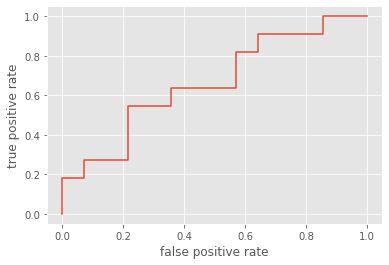

In [25]:
# 偽陽性率と真陽性率を算出
fpr = np.array([0, 0, 0, 1, 1, 2, 3, 3, 3, 3, 4, 5, 5, 6, 7, 8, 8, 8, 9, 10, 11, 12, 12, 13, 14])/14
tpr = np.array([0, 1, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11])/11

# ROC曲線をプロット
fig, ax = plt.subplots()
ax.step(fpr, tpr)
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
plt.show()

In [26]:
from sklearn.metrics import roc_curve

# 陽陰(Positive/Negative)を表すラベル
labels = np.array([1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0])

# 予測真陽性率
probs = np.array([0.98, 0.95, 0.9, 0.87, 0.85, 
                  0.8, 0.75, 0.71, 0.63, 0.55, 
                  0.51, 0.47, 0.43, 0.38, 0.35, 
                  0.31, 0.28, 0.24, 0.22, 0.19, 
                  0.15, 0.12, 0.08, 0.004, 0.01])

# 偽陽性率、真陽性率、しきい値を算出
fpr, tpr, threshold = roc_curve(labels, probs)
print('偽陽性率: ', fpr)
print('真陽性率: ', tpr)

偽陽性率:  [0.         0.         0.         0.07142857 0.07142857 0.21428571
 0.21428571 0.35714286 0.35714286 0.57142857 0.57142857 0.71428571
 0.71428571 0.85714286 0.85714286 1.        ]
真陽性率:  [0.         0.09090909 0.18181818 0.18181818 0.27272727 0.27272727
 0.54545455 0.54545455 0.63636364 0.63636364 0.81818182 0.81818182
 0.90909091 0.90909091 1.         1.        ]


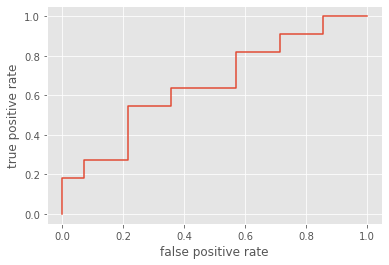

In [27]:
# roc_curveメソッドで取得した偽陽性率・真陽性率を利用してROC曲線をプロット
fig, ax = plt.subplots()
ax.step(fpr, tpr)
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
plt.show()

In [28]:
# AUCの算出
from sklearn.metrics import roc_auc_score
roc_auc_score(labels, probs)

0.6558441558441558

[sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)

[sklearn.metrics.roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

## ハイパーパラメーターの最適化

- ハイパーパラメーターとは
  - 学習時には値が決定されず、ユーザーが指定する必要となる値
  - 例えば
    - 決定木における「木の深さ(max_depthのこと)」
    - ランダムフォレストに置ける「決定木の個数(n_estimatorsのこと)」
- ハイパーパラメーター最適化を行う手法
  - グリッドサーチ(grid search)
    - ハイパーパラメーターに候補値を設定して、学習を繰り返し、最も予測が良いハイパーパラメーター値を選択する
    - 主に`交差検証`と組み合わせる
  - ランダムサーチ(random search)

### グリッドサーチ

In [29]:
# Irisデータセットの用意
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data, iris.target

# 学習データとテストデータに分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# 決定木(desiction tree)をインスタス化
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
param_grid = {'max_depth': [3, 4, 5]}

# 10分割の交差検証を実行
from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(clf, param_grid=param_grid, cv=10)
cv.fit(X_train, y_train)

# 最適な木の深さを確認
cv.best_params_

{'max_depth': 3}

In [30]:
# 最適なモデルの内容(ハイパーパラメーター)を確認する
cv.best_estimator_

DecisionTreeClassifier(max_depth=3)

In [31]:
# テストデータの予測をする
y_pred = cv.predict(X_test)
y_pred

array([1, 2, 2, 1, 0, 1, 1, 0, 0, 1, 2, 0, 1, 2, 2, 2, 0, 0, 1, 0, 0, 1,
       0, 2, 0, 0, 0, 2, 2, 0, 2, 1, 0, 0, 1, 1, 2, 0, 0, 1, 1, 0, 2, 2,
       2])

## クラスタリング

- `教師なし学習`の典型的なタスク
- データ間の類似性を計算して、データをグループにまとめるタスク
- アルゴリズム
  - k-means
  - 階層的クラスタリング

### k-means

以下のような手順となる

1. 各データにランダムに割り当てたラベルを用いて、各クラスタのデータの中心を、（いったん）そのクラスタの中心とする
2. 最も近いクラスタの中心を、各データの新しいクラスタのラベルとする
3. クラスタの中心が収束するまで、上記の2を繰り返す

![k-means](./img/k-means.png)

[日経TREND k平均方とは?](https://xtrend.nikkei.com/atcl/contents/18/00076/00008/)

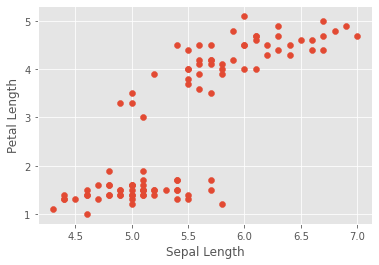

In [38]:
# データの用意
from sklearn.datasets import load_iris
iris = load_iris()
data = iris.data
# 先頭の100行、および0列名(Sepal Length)と2列目(Petal Length)のデータのみを利用する
X = data[:100, [0, 2]]

# データの散布図を描画
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1])
ax.set_xlabel('Sepal Length')
ax.set_ylabel('Petal Length')
plt.show()

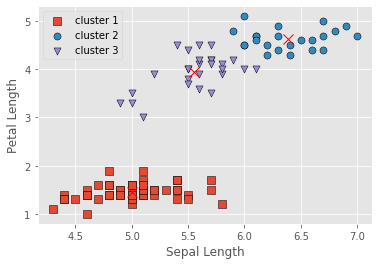

In [39]:
from sklearn.cluster import KMeans
# KMeansインスタンスの生成
km = KMeans(n_clusters=3,
            init='random',
            n_init=10,
            random_state=123)
# KMeansの実行
y_km = km.fit_predict(X)

# k-meansした結果を散布図に描画
fig, ax = plt.subplots()

# 3つのクラスターに分割されたデータを、それぞれプロット
ax.scatter(X[y_km == 0, 0], X[y_km == 0, 1], s=50, edgecolor='black', marker='s', label='cluster 1')
ax.scatter(X[y_km == 1, 0], X[y_km == 1, 1], s=50, edgecolor='black', marker='o', label='cluster 2')
ax.scatter(X[y_km == 2, 0], X[y_km == 2, 1], s=50, edgecolor='black', marker='v', label='cluster 3')

# 3つのクラスターの中心点をプロット
ax.plot(np.mean(X[y_km == 0, 0]), np.mean(X[y_km == 0, 1]), marker='x', markersize=10, color='red')
ax.plot(np.mean(X[y_km == 1, 0]), np.mean(X[y_km == 1, 1]), marker='x', markersize=10, color='red')
ax.plot(np.mean(X[y_km == 2, 0]), np.mean(X[y_km == 2, 1]), marker='x', markersize=10, color='red')

ax.set_xlabel('Sepal Length')
ax.set_ylabel('Petal Length')
ax.legend(loc='best')
plt.show()

[sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

以下、KMeansインスタンス生成時のパラメーター

- n_cluster
  - データを分けるクラスタ数を指定
- init
  - 初期値の与え方
  - 以下より選択

> ‘k-means++’ : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence.  
> ‘random’: choose n_clusters observations (rows) at random from data for the initial centroids.  

  - n_init
    - k-meansを実行する回数
  - max_iter
    - k-meansで反復する最大回数
  - tol
    - k-meansで収束を判定する許容誤差
  - random_state
    - 乱数のシードを固定する場合指定


### 階層的クラスタリング

- 凝集型
  - `地味にコツコツとデータをまとめていく`アプローチ
  - アプローチ・イメージ
    - 似ているデータをまとめて小さなクラスタをつくり
    - 次に、そのクラスタと似ているデータでクラスタをつくり
    - 最終的に、データが1つのクラスタにまとめられる
- 分割型
  - `すべてのデータが1つのクラスタに所属していると考え、順次クラスタ分割していく`アプローチ

#### 凝集型階層的クラスタリング

[sklearn.cluster.AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

`AgglomerativeClustering`インスタンス生成時のパラメーター

- n_cluster
  - データを分けるクラスタ数を指定
- affinity
  - データ間の距離を測る方法
  - 以下の例では`euclidean(ユークリッド距離)`を利用

> Metric used to compute the linkage. Can be “euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or “precomputed”.

- linkage
  - クラスタリング方法
  - `The algorithm will merge the pairs of cluster that minimize this criterion.`とのこと
  - 以下の例では`complete(最長距離法)`を利用

> Which linkage criterion to use. The linkage criterion determines which distance to use between sets of observation. The algorithm will merge the pairs of cluster that minimize this criterion.  
> ・‘ward’ minimizes the variance of the clusters being merged.  
> ・‘average’ uses the average of the distances of each observation of the two sets.  
> ・‘complete’ or ‘maximum’ linkage uses the maximum distances between all observations of the two sets.  
> ・‘single’ uses the minimum of the distances between all observations of the two sets.  

In [34]:
# データの用意
from sklearn.datasets import load_iris
iris = load_iris()
data = iris.data
# 先頭の100行、および0列名(Sepal Length)と2列目(Petal Length)のデータのみを利用する
X = data[:100, [0, 2]]

# 凝集型の階層的クラスタリングを実行
from sklearn.cluster import AgglomerativeClustering
# インスタンスの生成
ac = AgglomerativeClustering(n_clusters=3,
                             affinity='euclidean',
                             linkage='complete')
# 実行
labels = ac.fit_predict(X)
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2,
       0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0])

上記の凝集型階層的クラスタリングの結果を、樹形図にプロット

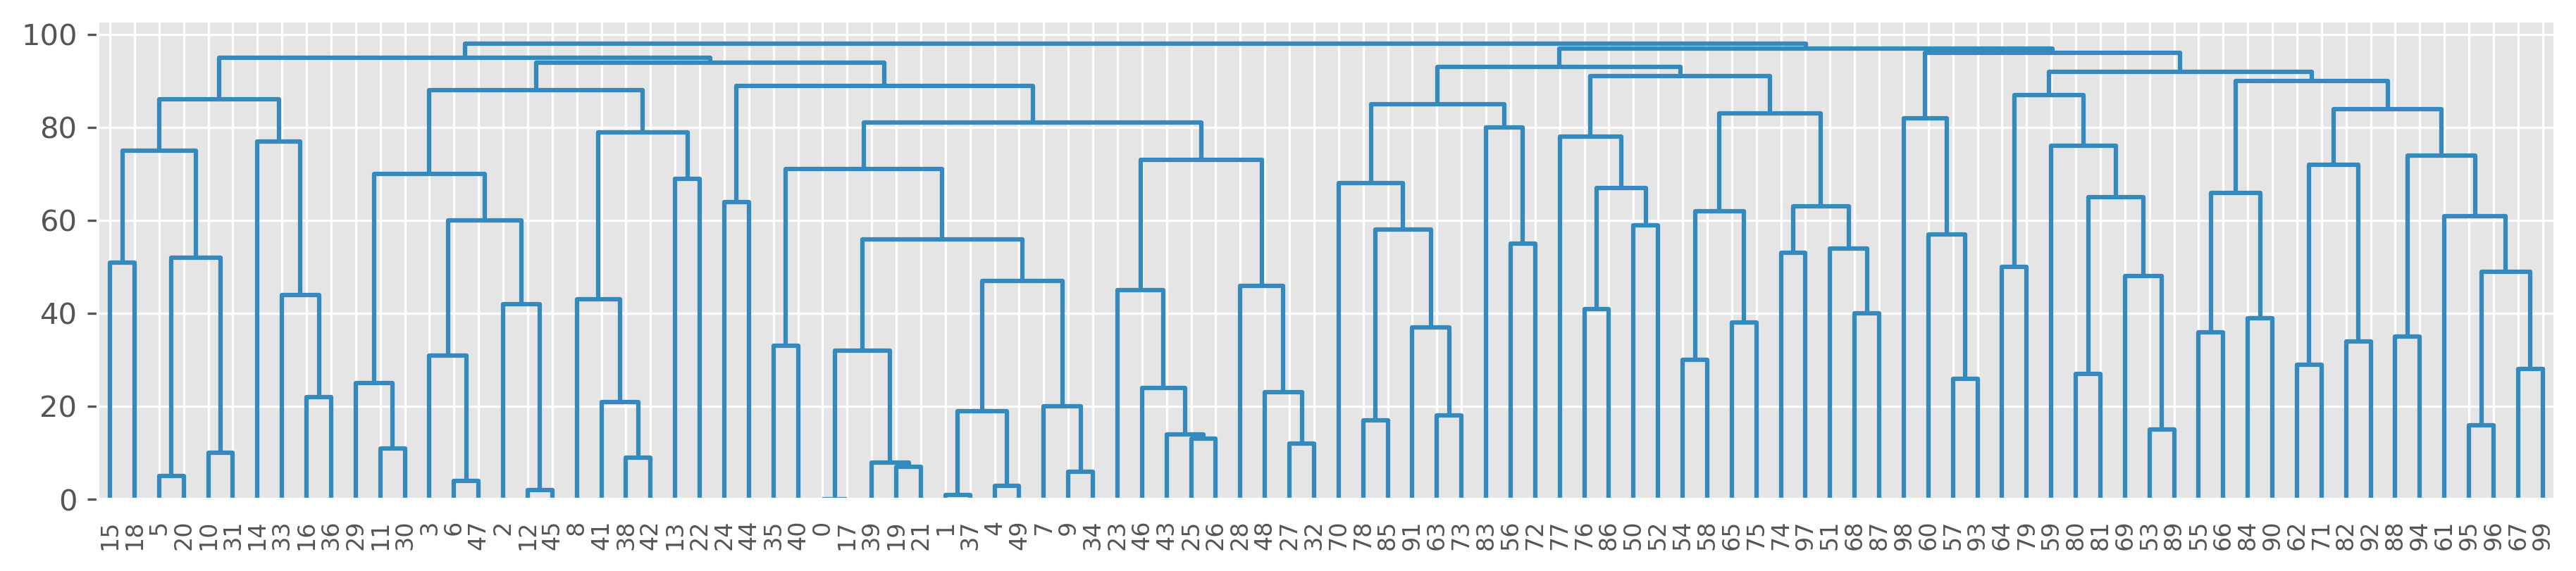

In [35]:
# 子クラスタとの関係を抽出
children = ac.children_
# クラスタ間の距離を抽出
distance = np.arange(children.shape[0])
# 各データの観測番号
no_of_observations = np.arange(2, children.shape[0]+2)
# 子クラスタ、クラスタ間の距離、観測番号を列方向に結合
linkage_matrix = np.hstack((children,
                            distance[:, np.newaxis],
                            no_of_observations[:, np.newaxis])).astype(float)

# 樹形図をプロット
from scipy.cluster.hierarchy import dendrogram
fig, ax = plt.subplots(figsize=(15, 3), dpi=300)
dendrogram(linkage_matrix, labels=np.arange(100), leaf_font_size=8, color_threshold=np.inf)
plt.show()